In [62]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import cv2
#plt.gray()
galaxy_name = 'DDO154'
filter = "V"
'''
#entered by hand ------------------------------------------------------------------------------------------------------------------------------------------------
center_v = [430 , 500]
center_b = [430 , 504]
center_u = [380 , 530]
center = center_v
'''
box_size = 200
window_size = (40, 40)
U_exp = 1800
B_exp = 1200
V_exp = 600
exp = [U_exp,B_exp,V_exp]

# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 154\d154u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 154\d154b.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 154\d154v.fits")
light_v = light_file_v[0].data

box_u = (100 , 100)
box_b = (130 , 130)
box_v = (170 , 170)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]

In [ ]:
def mag_correction(mag_map, mag_map_BV, correction_parameters, opacity, image_offset_V = (0, 0)):
    # offsetting images and correcting
    Dx, Dy = image_offset_V[0], image_offset_V[1]
    x1, y1 = len(mag_map_BV[0]), len(mag_map_BV)
    x2, y2 = len(mag_map[0]), len(mag_map)
    x3, y3 = x1 - Dx, y1 - Dy
    if x2 < x3:
        x3 = x2
    if y2 < y3:
        y3 = y2
    mag_map_corrected = np.zeros([y3, x3])
    for y in range(y3):
        for x in range(x3):
            mag_map_corrected[y][x] = mag_map[y][x] - mag_map_BV[y + Dy][x + Dx] * correction_parameters[2] - correction_parameters[0] - correction_parameters[1] * opacity
    return mag_map_corrected
B_map_c = V_map + mag_correction(lights[2], lights[1], correction_parameters = (0, 0, 0, 0), 0,image_offset_V = ())

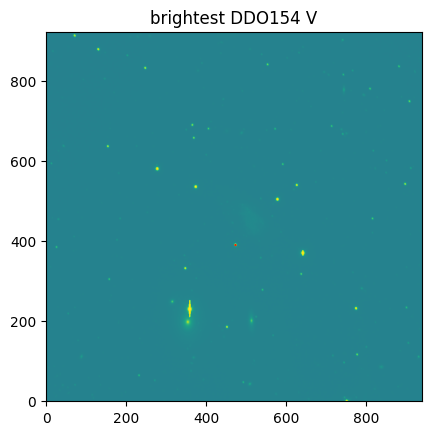

In [2]:
norm = ImageNormalize(vmin=0., stretch=LogStretch())

brightest_pixel = np.argmax(lights[2])
max_row, max_col = np.unravel_index(brightest_pixel, lights[2].shape)

fig, ax = plt.subplots()
# Display  image
ax.imshow(lights[2],norm=norm,origin="lower")
plt.title("brightest %s %s"%(galaxy_name,filters[2]))
# Mark the point with a red circle
circle = plt.Circle(( max_col , max_row), radius=1, fill=False, color='red')
ax.add_patch(circle)
plt.show() 


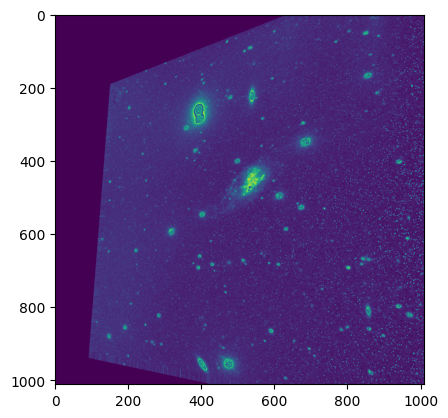

In [13]:
import cv2

# Load your FITS images (replace with actual data)
image1 = lights[0]
image1 = image1.astype(np.uint8, copy=False)

image2 = lights[1]
image2 = image2.astype(np.uint8, copy=False)

# Detect keypoints and compute descriptors
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(image1, None)
kp2, des2 = orb.detectAndCompute(image2, None)

# Match features
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Compute homography
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp image2 to align with image1
aligned_image2 = cv2.warpPerspective(image2, H, (image1.shape[1], image1.shape[0]))

# Now 'aligned_image2' is aligned with 'image1'


In [81]:
import astroalign as aa

print(lights[0].any() == np.nan)
target_fixed = lights[0].newbyteorder('L')
source_fixed = lights[1].newbyteorder('L')
print(target_fixed.any() == np.nan)

registered_image, footprint = aa.register(source_fixed, target_fixed)

False
False


C:\Users\AYSAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:58: RuntimeWarning: invalid value encountered in reduce
  return umr_any(a, axis, dtype, out, keepdims)
C:\Users\AYSAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\astroalign.py:570: RuntimeWarning: invalid value encountered in subtract
  image - bkg.back(), thresh, minarea=min_area, mask=mask


ValueError: data must be finite, check for nan or inf values

In [83]:
import numpy as np
data = lights[1]
data = lights[0]
# Assuming 'data' is your data array
has_nan = np.isnan(data).any()
has_inf = np.isinf(data).any()

if has_nan:
    print("Data contains NaN values.")
if has_inf:
    print("Data contains Inf values.")
else:
    print("your're good")


your're good


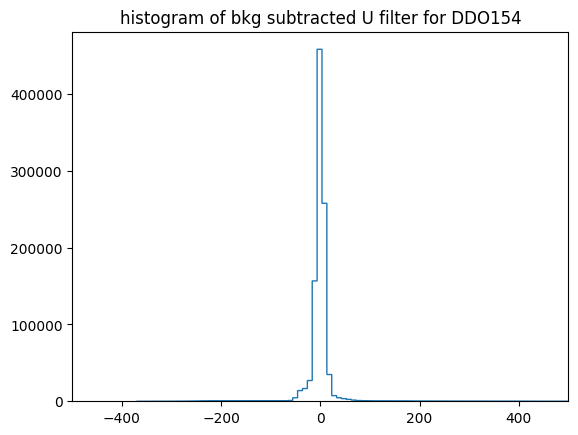

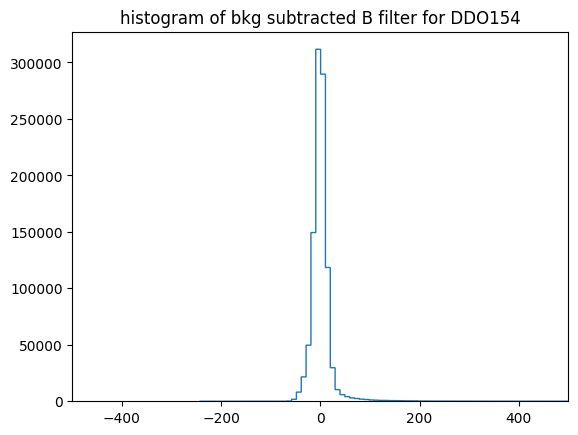

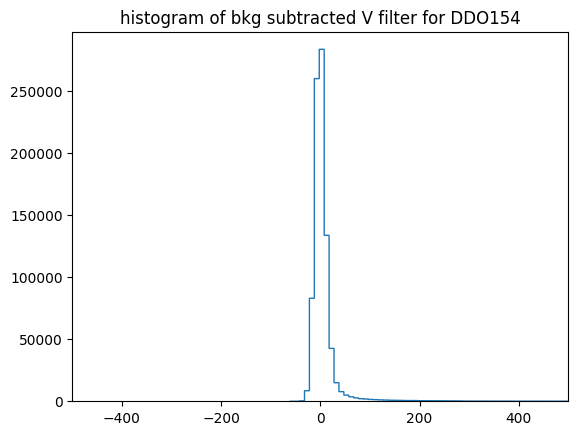

In [2]:
for i in range(0 , len(lights)): 
# create background------------------------------------------------------------------------------------------------------------------------------------------------
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(lights[i], boxes[i] , filter_size=(3, 3),
    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    data = lights[i] - bkg.background
    plt.figure()
    counts, bins = np.histogram(data, 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()


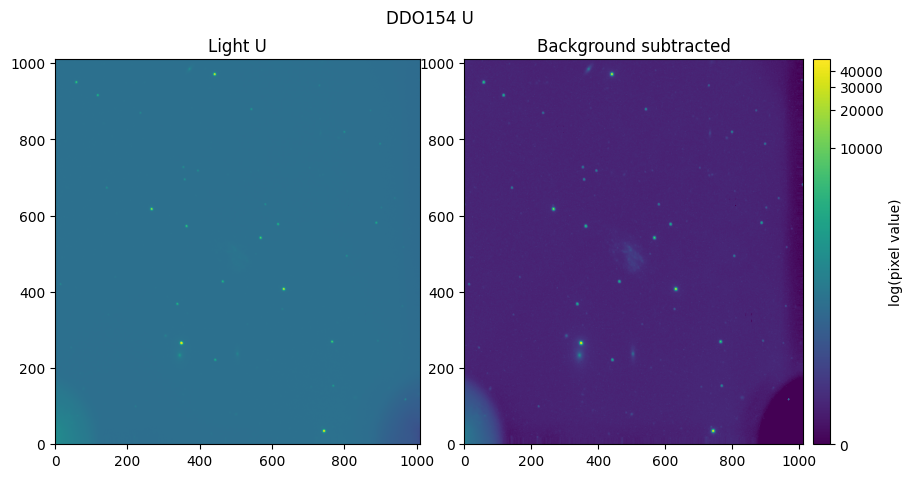

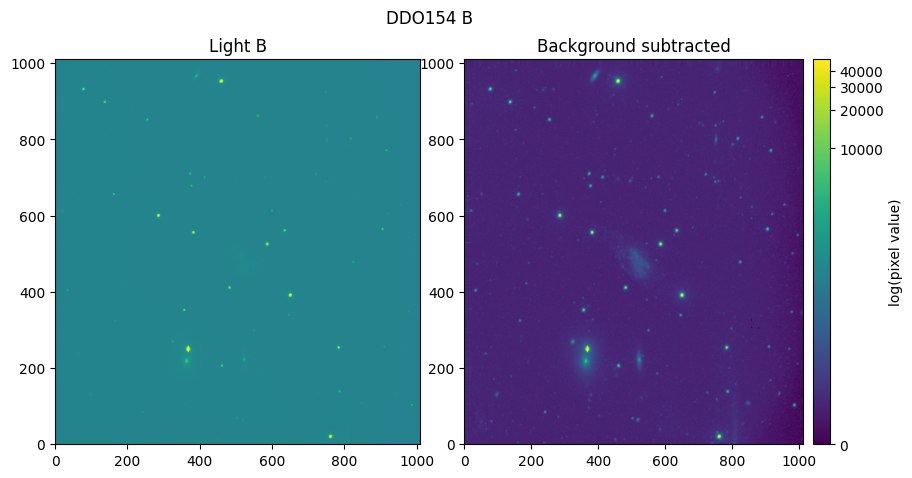

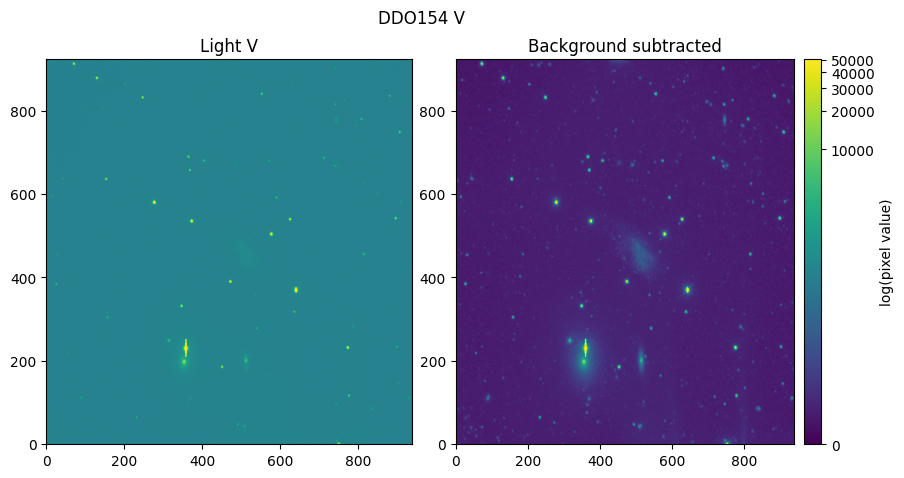

In [58]:
min_values = [50, 50, 40]
corrected_lights = []
for i in range(0 , len(lights)): 
# create background------------------------------------------------------------------------------------------------------------------------------------------------
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(lights[i], boxes[i] , filter_size=(3, 3),
    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    corrected_light = lights[i] - bkg.background + min_values[i]
    corrected_lights.append(corrected_light)

    norm = ImageNormalize(vmin=0., stretch=LogStretch())
    image1 = lights[i]
    image2 = corrected_lights[i]
    norm = ImageNormalize(vmin=0., stretch=LogStretch())
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the images---------------------------------------------------------------------------------------------------------------------
    im1 = axs[0].imshow(image1, origin = "lower" , aspect='auto' , norm = norm)
    im2 = axs[1].imshow(image2, origin = "lower" , aspect='auto' , norm = norm)
    axs[0].set_title('Light %s'%(filters[i]))
    axs[1].set_title('Background subtracted')
    fig.suptitle("%s %s"%(galaxy_name,filters[i]))
    # Remove the space between the two images
    plt.subplots_adjust(wspace=0.12)
    # Create an axis for the colorbar on the right side of axs[1].
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    # Create a colorbar
    cbar = fig.colorbar(im1, cax=cax)
    cbar.set_label('log(pixel value)')
    # Show the plot
    plt.show()
#export background corrected:-----------------------------------------------------------------------------------------------------------

    output_filename = '%s_%s_background_subtracted.fits'%(galaxy_name,filters[i])
    # Create a PrimaryHDU (header/data unit) from your array
    primary_hdu = fits.PrimaryHDU(corrected_light)
    # Create an HDUList and append the PrimaryHDU
    hdul = fits.HDUList([primary_hdu])
    # Write the HDUList to the FITS file
    hdul.writeto(output_filename, overwrite=True)




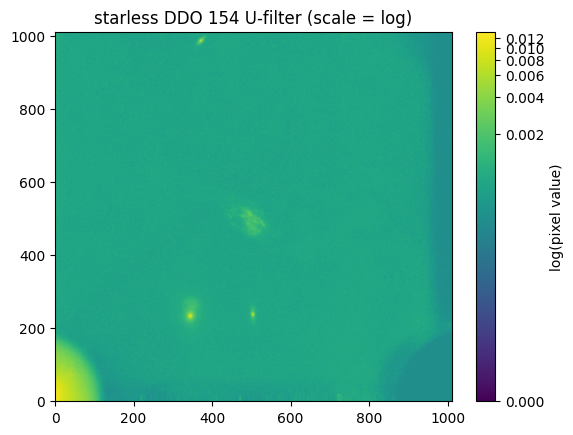

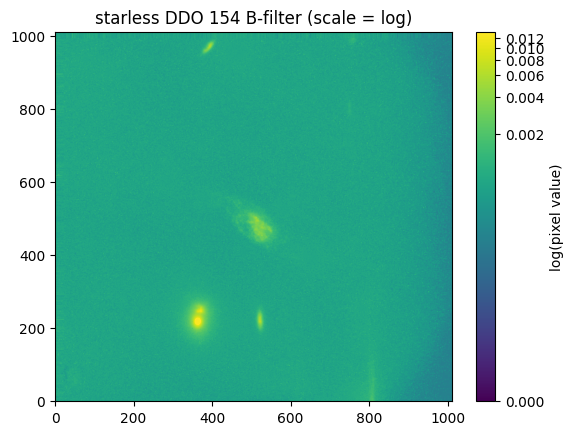

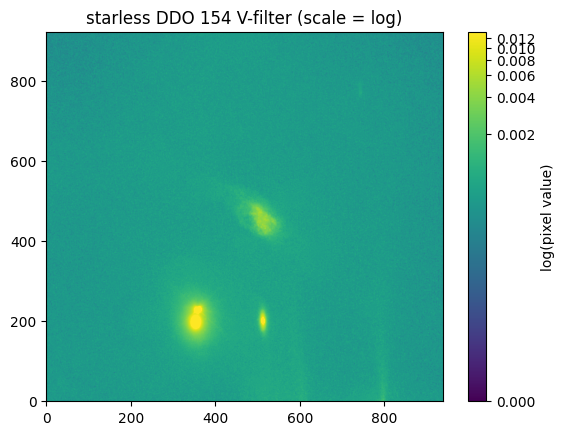

In [53]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_U_background_subtracted.fit")
starless_u = starless_file_u[0].data

starless_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_B_background_subtracted.fit")
starless_b = starless_file_b[0].data

starless_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_V_background_subtracted.fit")
starless_v = starless_file_v[0].data

starless = [starless_u , starless_b , starless_v]
norm = ImageNormalize(vmin=0., stretch=LogStretch())

for i in range(0 , len(starless)):
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

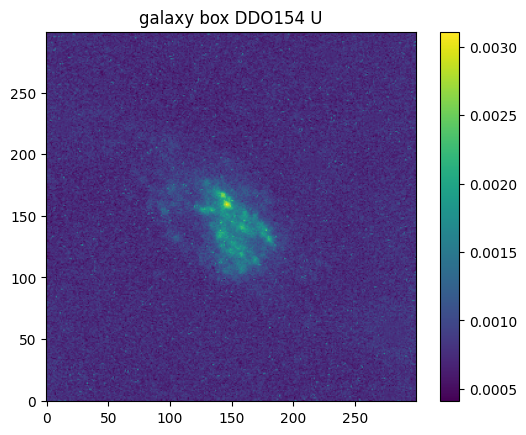

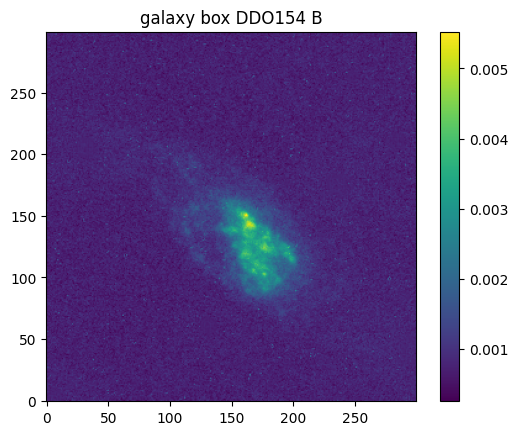

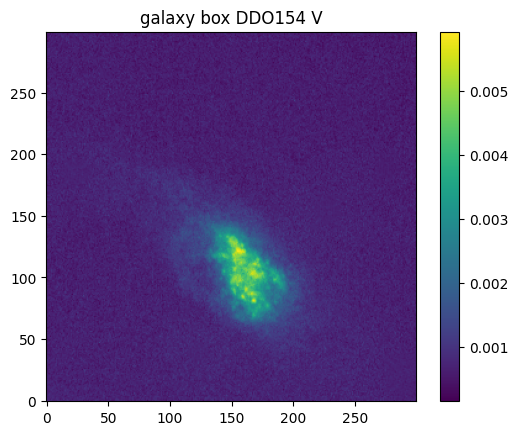

In [66]:
norm = ImageNormalize(vmin=0., stretch=LogStretch())
center = [500,500]
box_size = 150
# Slice the array
for i in range(0 , len(starless)):
    galaxy_box = starless[i][center[1]-box_size : center[1]+box_size , center[0]-box_size : center[0]+box_size]
    plt.imshow(galaxy_box, origin = "lower")
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
    '''
    image_center_of_mass = ndimage.center_of_mass(galaxy_box)
    #coordinates
    x, y = image_center_of_mass[1], image_center_of_mass[0]
    # Create a figure and axes
    fig, ax = plt.subplots()
    # Display  image
    ax.imshow(galaxy_box,norm=norm,origin="lower")
    plt.title("center of mass %s %s"%(galaxy_name,filter))
    # Mark the point with a red circle
    circle = plt.Circle((x, y), radius=1, fill=False, color='red')
    ax.add_patch(circle)
    plt.show() 
    '''

In [74]:
airmass_values=[1.16, 1.49, 1.11]
pixel_scale = 1.134
mU_values = [5.196, 0.4683865, -0.093,  0.]
mB_values = [3.562, 0.2586217, -0.0166, 0.]
mV_values = [3.017, 0.128904 ,  0.045,  0.]
m_values = [mU_values,mB_values,mV_values]

print(np.shape(starless_u))
print(np.shape(starless_b))
print(np.shape(starless_v))

def mag_table_correction(images, airmass_values, m_values):
    #first step of mag correction (turning each pixel into a magnitude/arcsec value)
    magnitude_tables=[]
    for i in range(0,len(images)): 
        image = images[i]
        flux = (image/(exp[i]*((pixel_scale)**2)))
        magnitude_table = (-2.5 * np.log10(flux) + 25) 
        magnitude_tables.append(magnitude_table)
 
    corrected_magnitude_tables = []
    U_B_magnitude_table = [magnitude_table[1],magnitude_table[2]]
    for j in range(0,len(U_B_magnitude_table)):
        i = j+1
        s1 = m_values[i][0]
        s2 = airmass_values[1]*m_values[i][1]
        s3=m_values[i][2]*(magnitude_tables[1] - magnitude_tables[2])
        s4=airmass_values[1]*m_values[i][3]*(magnitude_tables[1] - magnitude_tables[2])
        corrected_magnitude_table = magnitude_tables[i] - s1 - s2 - s3 - s4
        corrected_magnitude_tables.append(corrected_magnitude_table)
        '''
        plt.imshow( corrected_magnitude_table, origin = "lower")
        plt.title("corrected %s %s"%(galaxy_name,filter[i]))
        plt.colorbar()
        plt.show()
        '''
    return corrected_magnitude_tables

V_mag_table = mag_table_correction(starless,airmass_values,m_values)[1]
mag_box = V_mag_table[center[2][1]-box_size : center[2][1]+box_size , center[2][0]-box_size : center[2][0]+box_size]
plt.imshow(mag_box)
plt.title("My code, my starless")
plt.colorbar()
plt.show()

(1011, 1011)
(1011, 1011)
(924, 939)


ValueError: operands could not be broadcast together with shapes (1011,1011) (924,939) 